In [14]:
from __future__ import print_function

import h5py as h5
import numpy as np
import numba
import sklearn
import tensorflow as tf

print ("Numpy      ver. ", np.__version__)
print ("Numba      ver. ", numba.__version__)  ##  optimize numpy?!?
print ("H5Py       ver. ", h5.__version__)
print ("SKLearn    ver. ", sklearn.__version__)
print ("TensorFlow ver. ", tf.__version__)


import matplotlib
#matplotlib.use('agg')             ## Need for CMD
import matplotlib.pyplot as plt
%matplotlib inline

RATE=4096
NDATA=3000
###
ROOT_FOLDER = '/tmp/tf_tmp'
ROOT_FOLDER = '/tmp/tf_test'


Numpy      ver.  1.14.5
Numba      ver.  0.39.0
H5Py       ver.  2.7.1
SKLearn    ver.  0.19.2
TensorFlow ver.  1.10.1


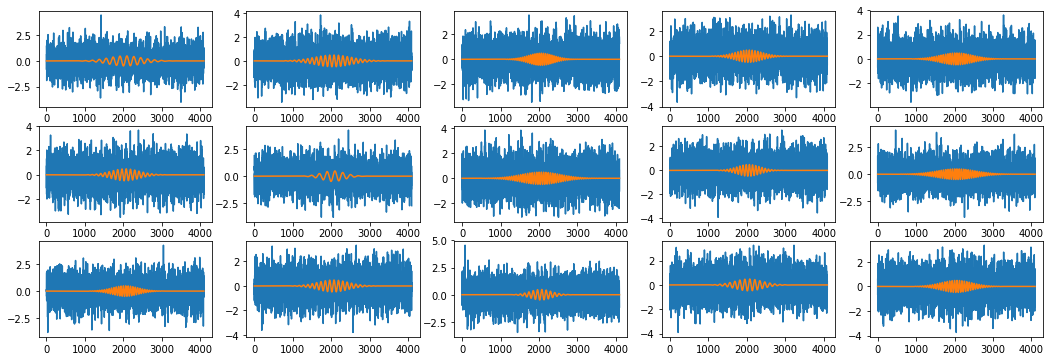

(6000, 4096)
(6000, 4096)


In [15]:
###
###  Prepare data: extract, transform, load (ETL)
###
import time
#from datetime import datetime
from sklearn.model_selection import train_test_split

#FLAGS = tf.app.flags.FLAGS
#tf.app.flags.DEFINE_string("train_data_path", "/home/yongcai/chinese_fenci/train.txt", "training data dir")
#tf.app.flags.DEFINE_string("log_dir", "./logs", " the log dir")
#tf.app.flags.DEFINE_integer("max_sentence_len", 80, "max num of tokens per query")
#tf.app.flags.DEFINE_integer("shuffle_buffer_size", )

from sklearn.utils import shuffle

## w in 0.05-0.15, f in 50-400, d in 0.2
def sin_gauss(n=8192,A=0.5,w=0.1,f=400, d=0, noise=True):
    x=np.linspace(-0.5,0.5,n)
    res = A*np.exp(-( (x-d)/w)**2 ) *np.sin(f*x)
    if noise:
        return res + np.random.normal(0,1,n)
    else:
        return res


_NOISE_COPY_ = 1
class SinGaussInject():
    
    def _add_noise(self, tag, A, nc, shift):
        NX = NDATA
        NN = self.rate
        
        var = np.zeros([NX,NN])
        
        for i in range(NX):
            w = np.random.uniform(low=0.05, high=0.2)   ## vary width
            f = np.random.uniform(low=100, high=500)    ## vary freq
            var[i,:] = sin_gauss(n=NN,A=A,w=w,f=f, d=shift, noise=False)
            
        NN = nc * NX
        noise = np.random.normal(0,1,(NN,self.rate))    
        X     = np.random.normal(0,1,(NX,self.rate))  + A * var[:NX,:]      
        if self.plot:
            plt.figure(figsize=(18,6))
            for i in range(len(X)):
                plt.subplot(3,5,i+1)         
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 13): break
            plt.show()

        X = np.vstack( (noise, X )  ).astype(np.float32)
        Y = np.array([0]*NN + [1]*NX).astype(np.float32).reshape(-1,1)
        #return shuffle(X, Y, random_state=0)
        return X, Y
    
    def __init__(self, plot=0):
        self.rate = RATE
        self.plot = plot
        
    def get_train_set(self, A=1.0, shift=0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/train_hp', A, nc = nc, shift=shift)
        return X, Y
    def get_val_set(self, A=1.0, shift=0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/val_hp', A, nc = nc, shift=shift)
        return X, Y
    def get_test_set(self, A=1.0, shift=0, nc = _NOISE_COPY_):
        X, Y = self._add_noise('/test_hp', A, nc = nc, shift=shift)
        return X, Y
    
tmp = SinGaussInject(plot=1)
X, Y = tmp.get_test_set(A=0.7)  
print(X.shape)
print(X.shape)


In [16]:
###
### Prepare NN model: small model
###
def model(x_, keep_prob, WIDTH):
    feature = tf.reshape(x_, [-1, WIDTH,1])

    args = {"padding":'valid', "activation":tf.nn.relu,            #None,
            "kernel_initializer":tf.truncated_normal_initializer(), 
            "bias_initializer":tf.truncated_normal_initializer()     }
            #"bias_initializer":tf.zeros_initializer()     }
    
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return out
        
    o1 = convl(feature, F=16, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    o2 = convl(o1,      F=32, K=8,  D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    o3 = convl(o2,      F=64, K=8,  D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    #o2 = convl(o1,      F=32, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    #o3 = convl(o2,      F=64, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    
    dim = o3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    o4 = tf.reshape(o3, [-1, fcnn])
    # Densely connected layer
    o4     = tf.layers.dense(o4, 64, activation=tf.nn.relu, name="fc")
    logits = tf.layers.dense(o4, 1, activation=None)
    
    return logits


In [17]:
###
### Prepare NN model: larger model
###
def model_hi(x_, keep_prob, WIDTH):
    """
    Model that return logits
    """
    args = {"padding":'valid', "activation":tf.nn.relu,  #None, 
        "kernel_initializer":tf.truncated_normal_initializer(), 
        "bias_initializer":tf.zeros_initializer()     }
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return out
        #return act(out)
    
    feature = tf.reshape(x_, [-1, WIDTH,1])
    c1 = convl(feature, F= 64, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    c2 = convl(c1,      F=128, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c3 = convl(c2,      F=256, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c4 = convl(c3,      F=512, K=32, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)

    dim = c4.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    l1 = tf.reshape(c4, [-1, fcnn])
    
    l2     = tf.layers.dense(l1, 128, activation=tf.nn.relu)
    l3     = tf.layers.dense(l2,  64, activation=tf.nn.relu)
    logits = tf.layers.dense(l3,   1, activation=None)
   
    return logits


In [18]:
###
###  Construct TF graph
###
tf.reset_default_graph()
DIM   = RATE
LRATE = 5e-5   ##-4
keep_prob = tf.placeholder(tf.float32)   ##  for dropout, not used.

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.float32, [None,1])

logits = model(x, keep_prob, DIM)
#logits = model_hi(features, keep_prob, DIM)

# Compute predictions
#with tf.name_scope('eval'):
predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
predict_class = tf.cast( tf.round(predict_prob), tf.int32 )
#with tf.name_scope('loss'):
## with reduction compared to tf.nn.softmax_cross_entropy_with_logits_v2 
loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=y)
##with tf.name_scope('optimizer'):
optimizer = tf.train.AdamOptimizer(LRATE).minimize(loss_op)
#optimizer = tf.train.AdadeltaOptimizer(LRATE, rho=0.90, epsilon=1e-08).minimize(loss_op)
#optimizer = tf.train.GradientDescentOptimizer(LRATE).minimize(loss_op)


#correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
#correct_prediction = tf.cast(correct_prediction, tf.float32)
#accuracy = tf.reduce_mean(correct_prediction)
_, accuracy    = tf.metrics.accuracy(labels=y, predictions=predict_class  )
#_, sensitivity = tf.metrics.sensitivity_at_specificity(labels=y, predictions=predict_op, specificity=0.005 )
_, sensitivity = tf.metrics.recall(labels=y, predictions=predict_class)


_, fp = tf.metrics.false_positives(labels=y, predictions=predict_class  )
_, fn = tf.metrics.false_negatives(labels=y, predictions=predict_class  )
_, tp = tf.metrics.true_positives(labels=y, predictions=predict_class  )
_, tn = tf.metrics.true_negatives(labels=y, predictions=predict_class  )

tf.summary.histogram('loss', loss_op)
tf.summary.scalar('loss', loss_op)
tf.summary.scalar('accuracy', accuracy)




<tf.Tensor 'accuracy_1:0' shape=() dtype=string>

In [19]:
def variable_summaries(var):
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope("summaries_%s"% var.name.replace("/", "_").replace(":", "_")):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

    
### check all vari\ables
#tf.global_variables_initializer()
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        #variable_summaries(v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

<tf.Variable 'conv1d/kernel:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv1d_1/kernel:0' shape=(8, 16, 32) dtype=float32_ref>
<tf.Variable 'conv1d_1/bias:0' shape=(32,) dtype=float32_ref>
<tf.Variable 'conv1d_2/kernel:0' shape=(8, 32, 64) dtype=float32_ref>
<tf.Variable 'conv1d_2/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'fc/kernel:0' shape=(3904, 64) dtype=float32_ref>
<tf.Variable 'fc/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(64, 1) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(1,) dtype=float32_ref>
<tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>
<tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>
<tf.Variable 'conv1d/kernel/Adam:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/kernel/Adam_1:0' shape=(16, 1, 16) dtype=float32_ref>
<tf.Variable 'conv1d/bias/Adam:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv1d/bias/Adam_1:0' shape

In [20]:
BATCH = 512
EPOCHS = 900
MONITOR = 10

PATIENCE = 4
#TOLLERENCE = 1.e-8
TOLLERENCE = 1.e-7

TEST_LIST = [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TEST_LIST = [1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A =   [2.0,1.6,1.4, 1.2, 1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5]

TEST_LIST = [1.2,1.1,1.0,0.9,0.8,0.7,0.6]
TRAIN_A =   [1.0,0.9,0.8]

GWdata = SinGaussInject()


#with tf.Session() as sess:
    


=get_train_setc== Reading  -------------- 5.37144112587
Trainning for A= 1.000000 , dataset size: 12000
  Epoch:   0, loss:  5.454e+01 acc: 0.61 sen: 0.34 sec:   2.2 speed:  3928.8 wf/sec
  Epoch:  10, loss:  4.398e+00 acc: 0.84 sen: 0.83 sec:  19.4 speed:  4947.6 wf/sec
  Epoch:  20, loss:  1.021e+00 acc:  0.9 sen: 0.90 sec:  36.4 speed:  5024.7 wf/sec
  Epoch:  30, loss:  5.029e-01 acc: 0.93 sen: 0.93 sec:  53.3 speed:  5061.6 wf/sec
  Epoch:  40, loss:  3.075e-01 acc: 0.94 sen: 0.94 sec:  70.3 speed:  5073.8 wf/sec
  Epoch:  50, loss:  1.249e-01 acc: 0.95 sen: 0.95 sec:  87.5 speed:  5074.5 wf/sec
  Epoch:  60, loss:  3.930e-02 acc: 0.96 sen: 0.96 sec: 104.5 speed:  5078.5 wf/sec
  Epoch:  70, loss:  1.663e-04 acc: 0.97 sen: 0.97 sec: 121.5 speed:  5084.4 wf/sec
  Epoch:  80, loss:  8.772e-04 acc: 0.97 sen: 0.97 sec: 138.4 speed:  5095.3 wf/sec
  Epoch:  90, loss:  7.803e-08 acc: 0.97 sen: 0.97 sec: 155.5 speed:  5092.4 wf/sec
  Epoch: 100, loss:  3.637e-08 acc: 0.98 sen: 0.98 sec: 

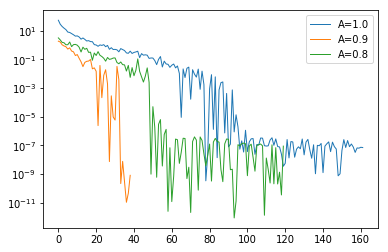

In [21]:
##
##  Training with fixed template ....
##

with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())

    merged = tf.summary.merge_all()   ## call merged to do every summary
    saver = tf.train.Saver(max_to_keep=50)   ## max_to_keep=4, keep_checkpoint_every_n_hours=2, ,write_meta_graph=False
 
    fig0 = plt.figure() ## plt loss 
    
    
    for amp in TRAIN_A:
        ## summarize to a new folder
        train_writer = tf.summary.FileWriter("%s/train_%4.2f" % (ROOT_FOLDER, amp ) )
        #train_writer.add_graph(tf.get_default_graph())
        #print('Saving graph to: %s' % ROOT_FOLDER)

        sess.run(tf.local_variables_initializer())

        time0 = time.time()
        X0, Y0 = GWdata.get_train_set(A=amp, nc=1)
        X1, Y1 = GWdata.get_val_set(A=amp, nc=1)
        X = np.vstack( (X0,X1) ) 
        Y = np.vstack( (Y0,Y1) ) 
        
        
        print('=get_train_setc== Reading  --------------',  time.time()-time0 )

        print("Trainning for A= %f , dataset size: %d"% (amp, len(X) ))

        patience = 0
        time0 = time.time()
        
        loss_in_epoches = []
        for e in range(EPOCHS):
            Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
            #Xt, _, Yt, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            
            STEPS   = int(len(Xt) / BATCH) 
            for i in range(STEPS):
                xbatch = Xt[i*BATCH:(i+1)*BATCH, :]
                ybatch = Yt[i*BATCH:(i+1)*BATCH, :]

                #_, loss = sess.run( [optimizer, loss_op], feed_dict={ x:xbatch, y:ybatch }   ) 
                #if (i%10==0): print('    Loss: %f', loss) 
                _ = sess.run( [optimizer], feed_dict={ x:xbatch, y:ybatch }   ) 

                #_, summary = sess.run( [optimizer, merged], feed_dict={ x:xbatch, y:ybatch }   ) 
                #train_writer.add_summary(summary, global_step=e)

            ### evaluate    
            loss, acc, sen = sess.run( [loss_op, accuracy, sensitivity],   feed_dict={x:Xv, y:Yv} )
            loss_in_epoches.append(loss)

            if e % MONITOR == 0:
                duration = time.time() - time0
                speed = STEPS * BATCH * (e+1) / duration
                print('  Epoch: %3d, loss: %10.3e acc: %4.2g sen: %4.2f sec: %5.1f speed: %7.1f wf/sec' 
                      % (e, loss, acc, sen, duration, speed) )
            if loss < TOLLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0
                
        save_path = saver.save(sess, "%s/%4.2f/save.ckpt" % (ROOT_FOLDER, amp ) )
        print("Model saved at %s" % save_path)
        
        ### plot in each epoch
        plt.semilogy(loss_in_epoches, lw=1, label="A=%s"%amp)
        
    plt.legend()
    #fig0.show()
    fig0.savefig("loss.png")
    
        
        


In [24]:
NUM_AUC=200000
thres=[10**(-i)-(1e-11) for i in range(10,-1,-1)]
print(thres)
_, fna = tf.metrics.false_negatives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, fpa = tf.metrics.false_positives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, tna = tf.metrics.true_negatives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
_, tpa = tf.metrics.true_positives_at_thresholds(labels=y, predictions=predict_prob,thresholds=thres)
print (fna)
    

[9e-11, 9.9e-10, 9.99e-09, 9.999e-08, 9.999899999999999e-07, 9.99999e-06, 9.999999e-05, 0.00099999999, 0.00999999999, 0.09999999999, 0.99999999999]
Tensor("false_negatives_1/AssignAdd:0", shape=(11,), dtype=float32_ref)


In [40]:
###
###  Testing...
###


BATCH = 4096

TEST_LIST = [1.2,1.1,1.0,0.9,0.8,0.7,0.6]
TRAIN_A =   [1.0,0.9,0.8]

TRAIN_A =   [0.8]

tf.reset_default_graph()
#saver = tf.train.import_meta_graph("%s/%4.2f/save.ckpt.meta" % (ROOT_FOLDER, TRAIN_A[0] ) )
#print ("Latest cpt: ",  tf.train.get_checkpoint_state("%s/%4.2f" % (ROOT_FOLDER, TRAIN_A[0] ) ) )


with tf.Session() as sess:
    
    ##test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
   
    sess.run(tf.global_variables_initializer())

    plt.figure()
    for m in TRAIN_A:
        #try:
        load_path = saver.restore(sess, "%s/%4.2f/save.ckpt" % (ROOT_FOLDER, m ) )
        print("Model restored from %s" % load_path )
        #except: 
        ##    continue

        gsen=[]

        for amp in TEST_LIST:
            
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_test_set(A=amp, nc=1)
            SIZE=len(X)
            #senatn, tpn, aaa = sess.run([senat, tp, predict_prob], feed_dict={ x: xbatch, y: ybatch })
            fpaa, fnaa,tpaa, tnaa, pre = sess.run([fpa, fna,tpa, tna, predict_prob], feed_dict={ x: X[:SIZE], y: Y[:SIZE] })
            
            print("tp=========", tpaa)
            print("fp---------", fpaa)
            print("tn=========", tnaa)
            print("fn---------", fnaa)
            #print( np.hstack( ( pre ,Y[:SIZE]    )) )
            #gsen.append(sen)
            
            tot = float(fpaa[0]+fnaa[0]+tpaa[0]+fpaa[0]) 
            roc_x_fpr = fpaa / tot
            roc_y_tpr = tpaa / tot
            plt.plot(roc_x_fpr[:-1],roc_y_tpr[:-1])
            print (roc_x_fpr)
            print (roc_x_fpr)
            #plt.xlim(0,1)
            plt.ylim(0,1)
            #plt.xscale('log')
            #plt.show()
            plt.savefig("roc.%f.png"%amp)
            
            
            #rint("Test for A= %4.2f : Sen: %9.3f"   % (amp, sen[0] ) )

        #lt.plot(TEST_LIST, gsen[0], label="model:%f"%m)
    
    #lt.xlabel("Amplitude of injected template")
    #lt.ylabel("Sensitivity")
    #plt.legend()
    #plt.show()


INFO:tensorflow:Restoring parameters from /tmp/tf_test/0.80/save.ckpt
Model restored from None


NameError: name 'fpa' is not defined

INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/1.00/save.ckpt
Test for A= 1.10 : Acc:     0.491, Sen:     1.000, TP/TN/FP/FN:  2012     0  2084     0 
Test for A= 1.00 : Acc:     0.496, Sen:     1.000, TP/TN/FP/FN:  2032     1  2063     0 
Test for A= 0.90 : Acc:     0.496, Sen:     1.000, TP/TN/FP/FN:  2029     1  2066     0 
Test for A= 0.80 : Acc:     0.507, Sen:     1.000, TP/TN/FP/FN:  2076     1  2019     0 
Test for A= 0.70 : Acc:     0.500, Sen:     1.000, TP/TN/FP/FN:  2047     0  2049     0 
Test for A= 0.60 : Acc:     0.491, Sen:     1.000, TP/TN/FP/FN:  2010     0  2086     0 
Test for A= 0.50 : Acc:     0.496, Sen:     1.000, TP/TN/FP/FN:  2028     2  2066     0 
Test for A= 0.40 : Acc:     0.494, Sen:     1.000, TP/TN/FP/FN:  2024     0  2071     1 
Test for A= 0.30 : Acc:     0.494, Sen:     1.000, TP/TN/FP/FN:  2023     1  2072     0 
Test for A= 0.20 : Acc:     0.500, Sen:     1.000, TP/TN/FP/FN:  2044     2  2050     0 
Test for A= 0.10 : Acc:     0.504, Sen:  

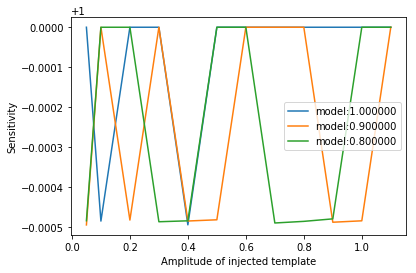

In [11]:
###
###  Testing...
###
BATCH = 4096
TEST_LIST = [1.1,1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.05]
TRAIN_A =   [1.0,0.9,0.8]
ROOT_FOLDER = '/tmp/tf_tmp'

##
#tf.reset_default_graph()
saver = tf.train.import_meta_graph("%s/%4.2f/save.ckpt.meta" % (ROOT_FOLDER, TRAIN_A[0] ) )
#print ("Latest cpt: ", tf.train.latest_checkpoint("%s/%4.2f" % (ROOT_FOLDER, TRAIN_A[0] ) ) )

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())
   
    plt.figure()
    for m in TRAIN_A:
        #try:
        saver.restore(sess, "%s/%4.2f/save.ckpt" % (ROOT_FOLDER, m ) )
        ###print("Model restored from %s" % load_path )
        #  except: 
        ## continue

        gacc=[]
        gsen=[]

        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_test_set(A=amp, nc=1)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    #plt.show()
    plt.savefig("infer.png")


INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/1.00/save.ckpt
Model restored from None
Test for shi= -0.40 : Acc:     0.500, Sen:     0.008, TP/TN/FP/FN:    17  2032    20  2027 
Test for shi= -0.37 : Acc:     0.497, Sen:     0.007, TP/TN/FP/FN:    14  2020    23  2039 
Test for shi= -0.34 : Acc:     0.502, Sen:     0.009, TP/TN/FP/FN:    18  2039    25  2014 
Test for shi= -0.30 : Acc:     0.501, Sen:     0.016, TP/TN/FP/FN:    33  2019    17  2027 
Test for shi= -0.27 : Acc:     0.505, Sen:     0.015, TP/TN/FP/FN:    30  2037    23  2006 
Test for shi= -0.24 : Acc:     0.506, Sen:     0.033, TP/TN/FP/FN:    68  2005    18  2005 
Test for shi= -0.21 : Acc:     0.543, Sen:     0.095, TP/TN/FP/FN:   194  2030    21  1851 
Test for shi= -0.18 : Acc:     0.612, Sen:     0.219, TP/TN/FP/FN:   444  2062    11  1579 
Test for shi= -0.14 : Acc:     0.703, Sen:     0.416, TP/TN/FP/FN:   848  2032    26  1190 
Test for shi= -0.11 : Acc:     0.816, Sen:     0.642, TP/TN/FP/FN:  1317  2024

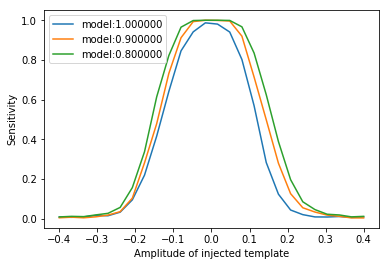

In [10]:
###
###  Testing shift data ...
###
BATCH = 4096
##TEST_LIST = [1.2,1.0,0.8]
TRAIN_A =   [1.0,0.9,0.8]

with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())

   
    plt.figure()
    for m in TRAIN_A:
        #try:
        load_path = saver.restore(sess, "%s/%4.2f/save.ckpt" % (ROOT_FOLDER, m ) )
        print("Model restored from %s" % load_path )
        #except: 
        ##    continue

        gacc=[]
        gsen=[]

        amp = 1.0
        SHIFT_LIST = np.linspace(-0.4,0.4,26)
        for shi in SHIFT_LIST:
            sess.run(tf.local_variables_initializer())
            
            X, Y  = GWdata.get_test_set(A=amp, nc=1, shift=shi)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for shi= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (shi, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(SHIFT_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    #plt.show()
    plt.savefig("infer.png")


In [307]:
sdlkfjslkfjsdklf

[([1], [2]), ([2], [3]), ([3], [4])]

INFO:tensorflow:Restoring parameters from /tmp/tf_tmp/model_1.20.ckpt
Model restored from None
Test for A= 1.40 : Acc:     0.710, Sen:     0.482, TP/TN/FP/FN:   312   607    40   335 
Test for A= 1.20 : Acc:     0.638, Sen:     0.340, TP/TN/FP/FN:   220   606    41   427 
Test for A= 1.00 : Acc:     0.573, Sen:     0.196, TP/TN/FP/FN:   127   614    33   520 
Test for A= 0.90 : Acc:     0.537, Sen:     0.151, TP/TN/FP/FN:    98   597    50   549 
Test for A= 0.80 : Acc:     0.512, Sen:     0.101, TP/TN/FP/FN:    66   597    46   585 
Test for A= 0.70 : Acc:     0.509, Sen:     0.085, TP/TN/FP/FN:    55   603    42   594 
Test for A= 0.60 : Acc:     0.512, Sen:     0.076, TP/TN/FP/FN:    49   613    38   594 
Test for A= 0.50 : Acc:     0.509, Sen:     0.063, TP/TN/FP/FN:    41   617    30   606 
Test for A= 0.40 : Acc:     0.506, Sen:     0.071, TP/TN/FP/FN:    46   609    36   603 
Test for A= 0.30 : Acc:     0.507, Sen:     0.068, TP/TN/FP/FN:    44   612    36   602 
Test for A= 0.2

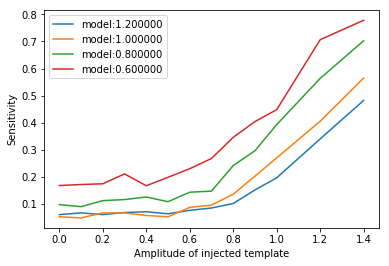

In [12]:
###
###  Testing... with shifted
###
BATCH = 4096
TEST_LIST = [1.2,1.1,1.0,0.9,0.8,0.7,0.6]


with tf.Session() as sess:
    
    test_writer  = tf.summary.FileWriter(ROOT_FOLDER + '/test')
    sess.run(tf.global_variables_initializer())

    TEST_LIST = [1.6,1.4, 1.2, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
    TRAIN_A = [1.2, 1.0, 0.8, 0.6]
    
    plt.figure()
    for m in TRAIN_A:
        try:
            load_path = saver.restore(sess, "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, m ) )
            print("Model restored from %s" % load_path )
        except:
            continue
            
        gacc=[]
        gsen=[]
        
        for amp in TEST_LIST:
            sess.run(tf.local_variables_initializer())
            X, Y  = GWdata.get_shifted_test_set(A=amp, shift=2000)
            Xts, _, Yts, _ = train_test_split(X, Y, test_size=0.01, shuffle=True, random_state=None)
            
            i=int(np.random.random()* int(len(Xts)/BATCH) )
            xbatch = Xts[i*BATCH:(i+1)*BATCH, :]
            ybatch = Yts[i*BATCH:(i+1)*BATCH, :]
            #Xts, Yts   = GWdata.get_shifted_test_set(A=amp, shift=2000)  

            acc, sen, ttp, ttn, tfp, tfn = sess.run([accuracy, sensitivity, tp, tn, fp, fn ], 
                                                          feed_dict={ x: xbatch, y: ybatch })
            gsen.append(sen)
            gacc.append(acc)
            print("Test for A= %4.2f : Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
                  % (amp, acc, sen, ttp, ttn, tfp, tfn) )

        plt.plot(TEST_LIST, gsen, label="model:%f"%m)
    
    plt.xlabel("Amplitude of injected template")
    plt.ylabel("Sensitivity")
    plt.legend()
    plt.show()


In [68]:
##
##  Re-Training with shifted template ....
##
GWdata = GWInject("white_h_fixed.h5")
#Xt, Xv, Yt, Yv = GWdata.get_train_val_set()
#nXt = Xt.shape[0]
#nXv = Xv.shape[0]

BATCH = 256
EPOCHS = 100
MONITOR = 2

PATIENCE = 4
TOLLERENCE = 1.e-7
###
ROOT_FOLDER = '/tmp/tf_tmp'
saver = tf.train.Saver(max_to_keep=10)

TEST_LIST = [1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
TRAIN_A = [1.1, 1.0, 0.9, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5]
#TEST_LIST = [1.0, 0.9, 0.8]
#TRAIN_A = [1.2]

with tf.Session() as sess:
   
    merged = tf.summary.merge_all()
    
    sess.run(tf.global_variables_initializer())

    for amp in TRAIN_A:
        sess.run(tf.local_variables_initializer())

        ### write
        train_writer = tf.summary.FileWriter("%s/retrain_%4.2f" % (ROOT_FOLDER, amp ) )
        #train_writer.add_graph(tf.get_default_graph())
        #print('Saving graph to: %s' % ROOT_FOLDER)
    
        ### Load model
        try:
            MODEL_FILE = "%s/model_%4.2f.ckpt" % (ROOT_FOLDER, amp )
            load_path = saver.restore(sess, MODEL_FILE )
            print("Model restored from %s" % load_path )
        except:
            continue
                    
        X, Y = GWdata.get_shifted_train_set(A=amp, shift=2000)
        print("Trainning for A= %f , dataset size: %d"% (amp, len(X) ))

        patience = 0
        time0 = time.time()
        for e in range(EPOCHS):
            
            ## training
            Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
            STEPS   = int(len(Xt) / BATCH) 
            for i in range(STEPS):
                xbatch = Xt[i*BATCH:(i+1)*BATCH, :]
                ybatch = Yt[i*BATCH:(i+1)*BATCH, :]

                _, summary = sess.run( [optimizer, merged], feed_dict={ x:xbatch, y:ybatch } )   ## 
                train_writer.add_summary(summary)

            ### evaluate    
            loss, acc, sen = sess.run( [loss_op, accuracy, sensitivity],   feed_dict={x:Xv, y:Yv} )
            if e % MONITOR == 0:
                time1 = time.time()
                duration = time1 - time0
                time0 = time1
                speed = STEPS * BATCH *MONITOR / duration
                print('  Epoch: %3d, loss: %10.3e acc: %4.2g sen: %4.2f sec: %5.1f speed: %7.1f wf/sec' 
                      % (e, loss, acc, sen, duration, speed) )
            if loss < TOLLERENCE:
                if patience > PATIENCE: break
                patience += 1
            else:
                patience = 0
            
        save_path = saver.save(sess, "%s/smodel_%4.2f.ckpt" % (ROOT_FOLDER, amp ) )
        print("Model saved at %s" % save_path)


IOError: Unable to open file (unable to open file: name = 'white_h_fixed.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [69]:
import glob
images = glob.glob('*.ipynb')
print (images)

['hello_ML.ipynb', 'play_LIGO_data.ipynb', '_template.ipynb', 'GWDA_lowlevel_oldfeed.ipynb', 'GWDL.ipynb', 'GWDA_get_SNR.ipynb', '0_GWDA.ipynb', 'GWDA_keras.ipynb', 'GWDA_lowlevel_genfeed_SLOW-Copy1.ipynb', 'GWDA_lowlevel_oldfeed_improved.ipynb', 'GWDA_lowlevel_oldfeed_improved-working.ipynb', 'GWDA_estimator.ipynb', '1_WF_whited.ipynb', 'Classifier-Copy1.ipynb', 'GWDA_lowlevel.ipynb']
